In [35]:
import os
import numpy as np
import torch
import torch.nn as nn
from EEGNet import EEGNet
from tqdm import tqdm
import LoadData as loaddata
from sklearn.model_selection import train_test_split

In [36]:
###============================ Sets the seed for random numbers ============================###
torch.manual_seed(1234)
np.random.seed(1234)

In [37]:
###============================ Use the GPU to train ============================###
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [38]:
###============================ Setup for saving the model ============================###
current_working_dir = os.getcwd()
filename = current_working_dir + '/best_model.pth'

In [39]:
###============================ Load data ============================###
data_path = "/home/pytorch/LiangXiaohan/MI_Dataverse/BCICIV_2a_gdf"
persion_data = 'A03T.gdf'

'''for BCIC Dataset'''
bcic_data = loaddata.LoadBCIC(persion_data, data_path)
eeg_data = bcic_data.get_epochs(tmin=-0., tmax=1, baseline=None, downsampled=None) # {'x_data':, 'y_labels':, 'fs':}

X = eeg_data.get('x_data')
Y = eeg_data.get('y_labels')

Extracting EDF parameters from /home/pytorch/LiangXiaohan/MI_Dataverse/BCICIV_2a_gdf/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
Loading data for 288 events and 251 original time points ...


/home/pytorch/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/mne/io/edf/edf.py:1155: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/home/pytorch/anaconda3/envs/pytorch_env/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


0 bad epochs dropped


In [40]:
###============================ Initialization parameters ============================###
chans           = X.shape[1]
samples         = X.shape[2]
kernelLength    = 64
kernelLength2   = 16
F1              = 8
D               = 2
F2              = F1 * D
dropoutRate     = 0.5
n_classes       = 4
training_epochs = 5
batch_size      = 32
kfolds          = 10
test_size       = 0.2
best_acc        = 0

In [41]:
###============================ Split data & Cross validate ============================###
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=0, shuffle=True)

train_indices, eval_indices = loaddata.cross_validate_sequential_split(X_train, Y_train, kfold=kfolds)

In [42]:
###============================ Initialization model ============================###
eegnet = EEGNet(n_classes, chans, samples, dropoutRate, kernelLength, kernelLength2, F1, D, F2)
eegnet = eegnet.to(device)
print(eegnet)
optimizer = torch.optim.Adam(eegnet.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss().to(device)

EEGNet(
  (EEGNetLayer): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), groups=8, bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): AvgPool2d(kernel_size=(1, 4), stride=4, padding=0)
      (4): Dropout(p=0.5, inplace=False)
    )
    (2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
      (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 8), stride=8, padding=0)
      (5): Dropout(p=0.5, inplace=False)
    )
  )
  

In [43]:
###============================ Train model ============================###
for iter in range(0, training_epochs):
    epoch_val_acc = 0

    for kfold in range(kfolds):
        train_idx = train_indices.get(kfold)
        eval_idx = eval_indices.get(kfold)
        # print(f'epoch {str(iter)}, Fold {str(kfold+1)}\n')
        x_train, x_eval = loaddata.split_xdata(X_train, train_idx, eval_idx)
        y_train, y_eval = loaddata.split_ydata(Y_train, train_idx, eval_idx)

        train_data = loaddata.BCICDataLoader(x_train, y_train, batch_size=batch_size)

        running_loss = 0
        running_accuracy = 0

        # create a minibatch
        eegnet.train()
        for inputs, target in tqdm(train_data):
            inputs = inputs.to(device).requires_grad_() # ([batch_size, chans, samples])
            target = target.to(device)

            output = eegnet(inputs)

            # update the weights
            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == target).float().mean()
            running_accuracy += acc / len(train_data)
            running_loss += loss.detach().item() / len(train_data)

        # print(f"Train : Epoch : {iter} - kfold : {kfold+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")

        # validation
        eegnet.eval()
        inputs = x_eval.to(device).requires_grad_()
        val_probs = eegnet(inputs)
        val_acc = (val_probs.argmax(dim=1) == y_eval.to(device)).float().mean()
        # print(f"Eval : Epoch : {iter} - kfold : {kfold+1} - acc: {val_acc:.4f}\n")
        epoch_val_acc += val_acc

    epoch_val_acc = epoch_val_acc/kfolds
    print(f"Eval : Epoch : {iter+1} - epoch_val_acc: {epoch_val_acc:.4f}\n")

    if epoch_val_acc > best_acc:
        torch.save({
            'model_state_dict': eegnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, filename)
        best_acc = epoch_val_acc
    print(f"best_acc={best_acc:.4f}\n")

100%|██████████| 7/7 [00:00<00:00, 31.44it/s]


Eval : Epoch : 1 - epoch_val_acc: 0.4652

best_acc=0.4652



100%|██████████| 7/7 [00:00<00:00, 29.96it/s]


Eval : Epoch : 2 - epoch_val_acc: 0.6304

best_acc=0.6304



100%|██████████| 7/7 [00:00<00:00, 30.34it/s]


Eval : Epoch : 3 - epoch_val_acc: 0.7043

best_acc=0.7043



100%|██████████| 7/7 [00:00<00:00, 32.36it/s]


Eval : Epoch : 4 - epoch_val_acc: 0.7130

best_acc=0.7130



100%|██████████| 7/7 [00:00<00:00, 33.16it/s]

Eval : Epoch : 5 - epoch_val_acc: 0.7609

best_acc=0.7609



In [44]:
###============================ Test model ============================###
X_test = torch.from_numpy(X_test).to(device).to(torch.float32).requires_grad_()
Y_test = torch.from_numpy(Y_test).to(device)

checkpoint = torch.load(filename)
eegnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict((checkpoint['optimizer_state_dict']))
eegnet.eval()
probs = eegnet(X_test)
acc = (probs.argmax(dim=1) == Y_test).float().mean()
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.793103 


Text(0.5, 1.0, 'Confusion Matrix')

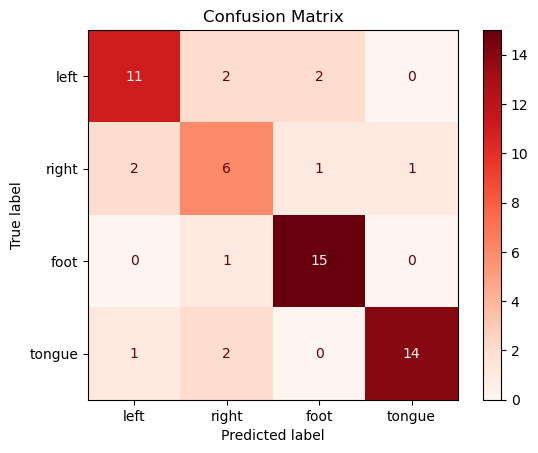

In [45]:
###============================ plot ============================###
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_test.cpu().numpy().tolist(), 
                                        probs.argmax(dim=1).cpu().numpy().tolist(), 
                                        display_labels=["left", "right", "foot", "tongue"], 
                                        cmap=plt.cm.Reds, 
                                        colorbar=True)
plt.title("Confusion Matrix")